<a href="https://colab.research.google.com/github/vanillaay/Python-project/blob/main/Trash_classification_better_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We found the project on http://tacodataset.org

We took the data from:
https://www.kaggle.com/kneroma/tacotrashdataset

In our project we were trying to **classify trash** through a Neural Network.

We used **VGG16** which is a Convolutional Network for classification and detection.

VGG16 models give a good accuracy but the model is very heavy which means **very long training times**.

We have read a great article about VGG16 which conviced us to use it in our project, even though it takes so long to train (**the article**: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c)

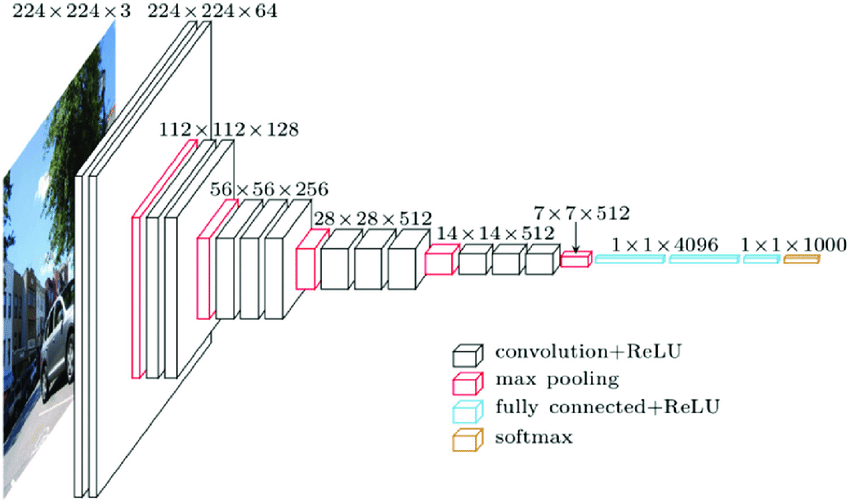

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing libraries**

In [ ]:
import os

import numpy as np
import pandas as pd
import json

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


import cv2
from sklearn.utils import shuffle
from keras.utils import np_utils
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop

**Checking statistics and graphs**

In [ ]:
dataset_path = '/content/drive/MyDrive/Python Advanced/Trash Detection Project/meta_df.csv'
anns_file_path = '/content/drive/MyDrive/Python Advanced/Trash Detection Project/data.zip (Unzipped Files)/annotations.json'

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

In [ ]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']

In [ ]:
num_categories = len(categories)
num_annotations = len(anns)
num_images = len(imgs)


# Load categories and main categories
category_names = []
main_names = []
main_ids = {}
main_last_name = ''                    
num_main = 0


for c in categories:
    category_names.append(c['name'])
    main_name = c['supercategory']

    # Adding new supercategory
    if main_name != main_last_name:           
        main_names.append(main_name)
        main_ids[main_name] = num_main
        main_last_name = main_name
        num_main += 1

print('Number of main categories:', num_main)
print('Number of categories: ', num_categories)
print('Number of annotations: ', num_annotations)
print('Number of images: ', num_images)

Number of main categories: 28
Number of categories:  60
Number of annotations:  4784
Number of images:  1500


All graphs presented below can be seen on the official website: http://tacodataset.org

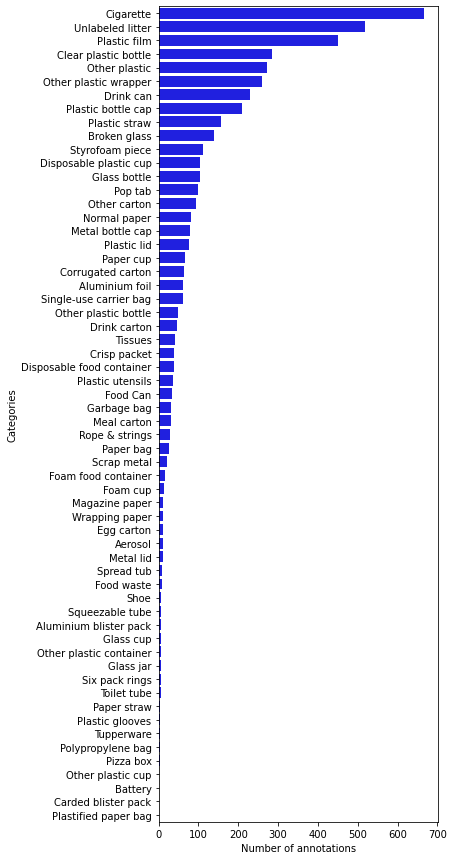

In [ ]:
# Count annotations
category_histogram = np.zeros(num_categories, dtype=int)
for a in anns:
    category_histogram[a['category_id']] += 1

# Plot
f, ax = plt.subplots(figsize=(5,15))

df = pd.DataFrame({'Categories': category_names, 'Number of annotations': category_histogram})
df = df.sort_values('Number of annotations', 0, False)

plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")

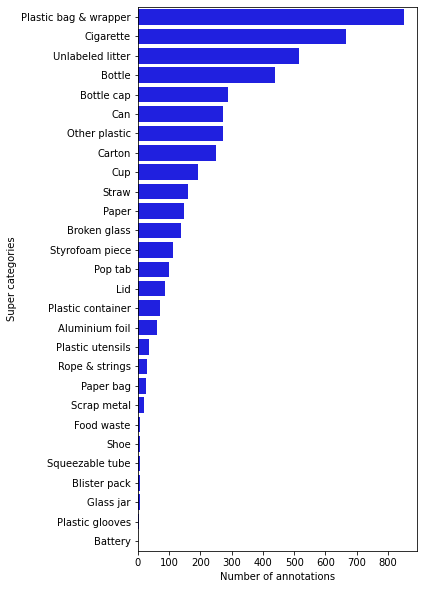

In [ ]:
cat_ids_2_supercat_ids = {}
for c in categories:
    cat_ids_2_supercat_ids[c['id']] = main_ids[c['supercategory']]

# Count annotations
super_cat_histogram = np.zeros(num_main,dtype=int)
for ann in anns:
    cat_id = ann['category_id']
    super_cat_histogram[cat_ids_2_supercat_ids[cat_id]] +=1
    
# Plot
f, ax = plt.subplots(figsize=(5,10))

d ={'Super categories': main_names, 'Number of annotations': super_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total", color="b")

The amount of samples per class is skewed. The inadequate number of samples observed in a large number of classes makes prediction for those classes difficult and requires increased data collection.

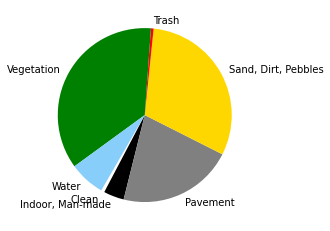

In [ ]:
# Where is the trash?
scene_categories = dataset['scene_categories']
scene_name = []
for scene in scene_categories:
    scene_name.append(scene['name'])

num_scenes = len(scene_categories)
scene_histogram = np.zeros(num_scenes,dtype=int)

for scene_ann in dataset['scene_annotations']:    
    scene_ann_ids = scene_ann['background_ids']
    for scene_ann_id in scene_ann_ids:
        if scene_ann_id<len(scene_categories):
            scene_histogram[scene_ann_id]+=1

df = pd.DataFrame({'scene_cats': scene_categories, 'nr_annotations': scene_histogram})
 
# Plot
colors = ['white','black','gray', 'gold', 'red','green','lightskyblue']
plt.pie(scene_histogram, labels=scene_name, colors = colors,
      shadow=False, startangle=-120)

plt.show()

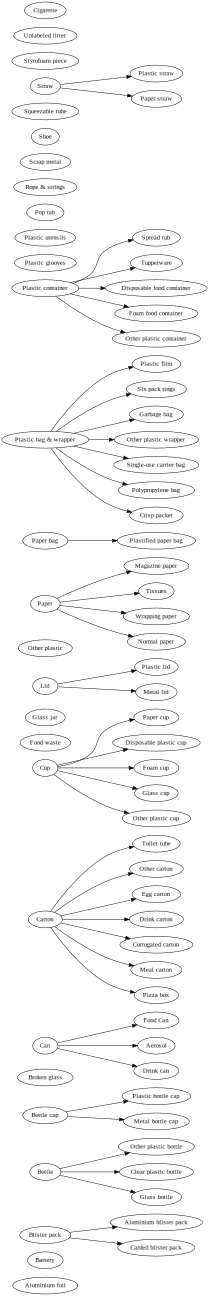

In [ ]:
from graphviz import Digraph

dot = Digraph('Dataset graph', filename='asd.gv')
dot.attr(rankdir='LR', size='15,18')

for cat_it in categories:
    dot.node(cat_it['name'])
    if cat_it['name']==cat_it['supercategory']:
        dot.node(cat_it['supercategory'])
    else:
        dot.edge(cat_it['supercategory'], cat_it['name'])
dot

**Importing the data**

In [ ]:
def load_samples(csv_file):
    data = pd.read_csv(os.path.join('data',csv_file))
    data = data[['img_file','cat_id','cat_name']]
    file_names = list(data.iloc[:,0])    
    labels = list(data.iloc[:,1])
    label_names = list(data.iloc[:,2])
    samples=[]
    for samp,lab in zip(file_names,labels):
        samples.append([samp,lab])
    return samples

In [ ]:
data = pd.read_csv(os.path.join('data','/content/drive/MyDrive/Python Advanced/Trash Detection Project/meta_df.csv'))
data.head()

,img_id,img_width,img_height,img_file,cat_id,cat_name,supercategory,ann_id,x,y,width,height,area
0,0,1537,2049,batch_1/000006.jpg,6,Glass bottle,Bottle,1,517.0,127.0,447.0,1322.0,403954.0
1,1,1537,2049,batch_1/000008.jpg,18,Meal carton,Carton,2,1.0,457.0,1429.0,1519.0,1071259.5
2,1,1537,2049,batch_1/000008.jpg,14,Other carton,Carton,3,531.0,292.0,1006.0,672.0,99583.5
3,2,1537,2049,batch_1/000010.jpg,5,Clear plastic bottle,Bottle,4,632.0,987.0,500.0,374.0,73832.5
4,2,1537,2049,batch_1/000010.jpg,7,Plastic bottle cap,Bottle cap,5,632.0,989.0,44.0,51.0,915.0


In [ ]:
data_new = data[['cat_name','cat_id']]
data_new.head()

,cat_name,cat_id
0,Glass bottle,6
1,Meal carton,18
2,Other carton,14
3,Clear plastic bottle,5
4,Plastic bottle cap,7


In [ ]:
data_new.groupby('cat_id').first().head()

,cat_name
cat_id,
0,Aluminium foil
1,Battery
2,Aluminium blister pack
3,Carded blister pack
4,Other plastic bottle


In [ ]:
data_path = '/content/drive/MyDrive/Python Advanced/Trash Detection Project/meta_df.csv'

samples = load_samples(data_path)
#print(samples[0])
samples = shuffle(samples,random_state=32)
#print(samples[0])
print('total no of images: ',len(samples))

train_sample = samples[0:4000]
test_sample = samples[4000:len(samples)]
print('total no of train images: ',len(train_sample))
print('total no of test images: ',len(test_sample))

total no of images:  4784
total no of train images:  4000
total no of test images:  784


**Data preperation**

In [ ]:
root_dir = '/content/drive/MyDrive/Python Advanced/Trash Detection Project/data.zip (Unzipped Files)/all_batches'

In [ ]:
def data_generator(samples, batch_size=32,shuffle_data=True,resize=300):
    num_samples = len(samples)
    while True:


        
        for offset in range(0, num_samples, batch_size):            
            batch_samples = samples[offset:offset+batch_size]            
            X_train = []
            y_train = []            
            for batch_sample in batch_samples:                
                img_name = batch_sample[0]
                label = batch_sample[1]
                img =  cv2.imread(os.path.join(root_dir,img_name))
                img = cv2.resize(img,(resize,resize))
                img = img / 255
                X_train.append(img)
                y_train.append(label)
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            y_train = to_categorical(y_train, num_classes=60)       
            yield X_train, y_train

In [ ]:
datagen = data_generator(samples,batch_size=8)
x,y = next(datagen)

In [ ]:
print ('x_shape: ', x.shape)
print ('labels: ', y)

x_shape:  (8, 300, 300, 3)
labels:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 

**Showing the pictures**

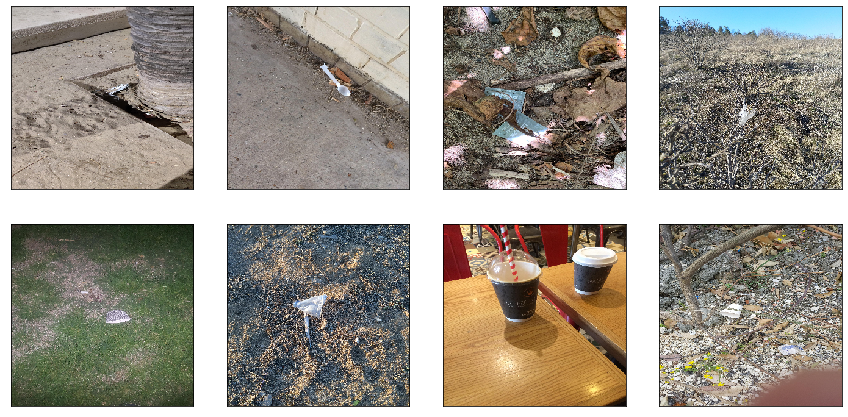

In [ ]:
fig = plt.figure(1,figsize=(12,12))
for i in range(8):
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.imshow(x[i][:,:,::-1], interpolation='none')
    #plt.title("class_label: {}".format(y[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
batch_size = 32
num_train_samples = len(train_sample)
num_test_samples = len(test_sample)
train_generator = data_generator(train_sample, batch_size=32)
validation_generator = data_generator(test_sample, batch_size=32)

**Creating a model**

In [ ]:
# model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

model = VGG16(include_top=False, input_shape=(300, 300, 3))
for layer in model.layers:
    layer.trainable = False
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu')(flat1)
class1 = Dense(64, activation='relu')(flat1)

output = Dense(60, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
#model.summary()

# Compile
model.compile(optimizer = RMSprop() , loss = "categorical_crossentropy", metrics=["accuracy"])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples // batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=num_test_samples // batch_size)
model.save_weights('model5.h5')

58892288/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
125/125 [==============================] - 1636s 13s/step - loss: 5.2778 - accuracy: 0.0983 - val_loss: 3.5126 - val_accuracy: 0.1641
Epoch 2/20
125/125 [==============================] - 599s 5s/step - loss: 3.1851 - accuracy: 0.2088 - val_loss: 3.3536 - val_accuracy: 0.1875
Epoch 3/20
125/125 [==============================] - 601s 5s/step - loss: 2.9756 - accuracy: 0.2403 - val_loss: 3.0746 - val_accuracy: 0.2135
Epoch 4/20
125/125 [==============================] - 599s 5s/step - loss: 2.8033 - accuracy: 0.2676 - val_loss: 3.2307 - val_accuracy: 0.2174
Epoch 5/20
125/125 [==============================] - 600s 5s/step - loss: 2.7163 - accuracy: 0.2872 - val_loss: 3.2345 - val_accuracy: 0.2383
Epoch 6/20
125/125 [==============================] - 599s 5s/step - loss: 2.6229 - accuracy: 0.2986 - val_loss: 3.1404 - val_accuracy: 0.2708
Epoch 7/20
125/125 [==============================] - 599s 5s/step - loss: 2.5503 - accuracy: 0.3146 - val_loss: 3.2163 - val_accuracy: 0.27

**As mentioned above: The low accuracy is unfortunately due to the long tail distribution.**

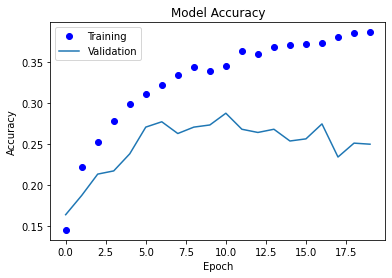

In [ ]:
plt.plot(history.history["accuracy"],"bo")
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"])
plt.show()

**Prediction**

In [ ]:
# TEST

root_dir+samples[1][0]

'/content/drive/MyDrive/Python Advanced/Trash Detection Project/data.zip (Unzipped Files)/all_batchesbatch_1/000086.JPG'

In [ ]:
img_test =  cv2.imread(os.path.join(root_dir,samples[1][0]))
img_test = cv2.resize(img_test,(300,300))
img_test = img_test/255

(300, 300, 3)


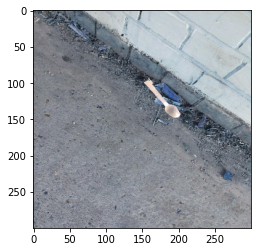

In [ ]:
print(img_test.shape)
plt.imshow(img_test)
img_test = img_test.reshape(-1, 300, 300, 3)

In [ ]:
pred_class = np.argmax(model.predict(img_test))

In [ ]:
if (pred_class == 0):
    print('it is an image of : ', "Aluminium foil")
elif pred_class == 1:
    print('it is an image of : ', "Battery")
elif pred_class == 2:
    print('it is an image of : ', "Aluminium blister pack")
elif pred_class == 3:
    print('it is an image of : ', "Carded blister pack")
elif pred_class == 4:
    print('it is an image of : ', "Other plastic bottle")
elif pred_class == 5:
    print('it is an image of : ', "Clear plastic bottle")
elif pred_class == 6:
    print('it is an image of : ', "Glass bottle")
elif pred_class == 7:
    print('it is an image of : ', "Plastic bottle cap")
elif pred_class == 8:
    print('it is an image of : ', "Metal bottle cap")
elif pred_class == 9:
    print('it is an image of : ', "Broken glass")
elif pred_class == 10:
    print('it is an image of : ', "Food Can")
elif pred_class == 11:
    print('it is an image of : ', "Aerosol")
elif pred_class == 12:
    print('it is an image of : ', "Drink can")
elif pred_class == 13:
    print('it is an image of : ', "Toilet tube")
elif pred_class == 14:
    print('it is an image of : ', "Other carton")
elif pred_class == 15:
    print('it is an image of : ', "Egg carton")
elif pred_class == 16:
    print('it is an image of : ', "Drink carton")
elif pred_class == 17:
    print('it is an image of : ', "Corrugated carton")
elif pred_class == 18:
    print('it is an image of : ', "Meal carton")
elif pred_class == 19:
    print('it is an image of : ', "Pizza box")
elif pred_class == 20:
    print('it is an image of : ', "Paper cup")
elif pred_class == 21:
    print('it is an image of : ', "Disposable plastic cup")
elif pred_class == 22:
    print('it is an image of : ', "Foam cup")
elif pred_class == 23:
    print('it is an image of : ', "Glass cup")
elif pred_class == 24:
    print('it is an image of : ', "Other plastic cup")
elif pred_class == 25:
    print('it is an image of : ', "Food waste")
elif pred_class == 26:
    print('it is an image of : ', "Glass jar")
elif pred_class == 27:
    print('it is an image of : ', "Plastic lid")
elif pred_class == 28:
    print('it is an image of : ', "Metal lid")
elif pred_class == 29:
    print('it is an image of : ', "Other plastic")
elif pred_class == 30:
    print('it is an image of : ', "Magazine paper")
elif pred_class == 31:
    print('it is an image of : ', "Tissues")
elif pred_class == 32:
    print('it is an image of : ', "Wrapping paper")
elif pred_class == 33:
    print('it is an image of : ', "Normal paper")
elif pred_class == 34:
    print('it is an image of : ', "Paper bag")
elif pred_class == 35:
    print('it is an image of : ', "?")
elif pred_class == 36:
    print('it is an image of : ', "Plastic film")
elif pred_class == 37:
    print('it is an image of : ', "Six pack rings")
elif pred_class == 38:
    print('it is an image of : ', "Garbage bag")
elif pred_class == 39:
    print('it is an image of : ', "Other plastic wrapper")
elif pred_class == 40:
    print('it is an image of : ', "Single-use carrier bag")
elif pred_class == 41:
    print('it is an image of : ', "Polypropylene bag")
elif pred_class == 42:
    print('it is an image of : ', "Crisp packet")
elif pred_class == 43:
    print('it is an image of : ', "Spread tub")
elif pred_class == 44:
    print('it is an image of : ', "Tupperware")
elif pred_class == 45:
    print('it is an image of : ', "Disposable food container")
elif pred_class == 46:
    print('it is an image of : ', "Foam food container")
elif pred_class == 47:
    print('it is an image of : ', "Other plastic container")
elif pred_class == 48:
    print('it is an image of : ', "Plastic glooves")
elif pred_class == 49:
    print('it is an image of : ', "Plastic utensils")
elif pred_class == 50:
    print('it is an image of : ', "Pop tab")
elif pred_class == 51:
    print('it is an image of : ', "Rope & strings")
elif pred_class == 52:
    print('it is an image of : ', "Scrap metal")
elif pred_class == 53:
    print('it is an image of : ', "Shoe")
elif pred_class == 54:
    print('it is an image of : ', "Squeezable tube")
elif pred_class == 55:
    print('it is an image of : ', "Plastic straw")
elif pred_class == 56:
    print('it is an image of : ', "Paper straw")
elif pred_class == 57:
    print('it is an image of : ', "Styrofoam piece")
elif pred_class == 58:
    print('it is an image of : ', "Unlabeled litter")
elif pred_class == 59:
    print('it is an image of : ', "Cigarette")

it is an image of :  Unlabeled litter


A 40% accuracy for such skewed data is pretty **good**.

For to **future** we are possibly planning to find more data to balance it out and get better results.